In [1]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import string


In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
if torch.cuda.is_available(): 
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


In [3]:
filename = "All_Full_EA"
MAX_LEN = 500 #due to the max length of the token [most BERT agree 512 token] => 512 without features or labels in it
# batch size = 16, 32
batch_size = 24

In [4]:
df_sentiment = pd.read_csv('../Data/THR_DLR_CLA_V2_Primary_Full_EA.csv')
df_sentiment

,News Title,News_Intro,News_Desc,News_All,Gambling,Murder,Sexual Abuse,Theft/Burglary,Drug,Battery/Assault,Accident,Non-Crime
0,ตร.นนท์จับหนุ่มแท็กซี่ขโมยเนื้อหมูของร้านตามสั...,ตำรวจ สภ.รัตนาธิเบศร์ จับกุมโชเฟอร์แท็กซี่ตามห...,ตำรวจ สภ.รัตนาธิเบศร์ จับกุมโชเฟอร์แท็กซี่ตามห...,ตร.นนท์จับหนุ่มแท็กซี่ขโมยเนื้อหมูของร้านตามสั...,0,0,0,1,0,0,0,0
1,"ครอบครัว ""ฮ้อแสงชัย"" เชื่อคดี ""เบนซ์ชนฟอร์ด"" จ...",น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุต...,น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุต...,"ครอบครัว ""ฮ้อแสงชัย"" เชื่อคดี ""เบนซ์ชนฟอร์ด"" จ...",0,0,0,0,0,0,1,0
2,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,0,0,0,0,0,0,0,1
3,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,0,1,0,0,1,0,0,0
4,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8562,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,รองโฆษก ตร.แจงกรณีสื่อแฉดาราสร้างเรื่องหลอกลวง...,ตร.แจง ดารากุเรื่องเป็นเซียนหวย อาจเข้าข่ายผิด...,0,0,0,0,0,0,0,1
8563,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,พบศพหนุ่มวัย 22 ปี ถูกยิงด้วยปืน 9 มม. ตาย 1 ศ...,หนุ่มชาวบ้านที่ถูกยิงดับใต้สะพานที่บาเจาะ ตร.ค...,0,1,0,0,1,1,0,0
8564,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สน.สายไหม นำทีมข้าราชการตำรวจในสังกัด และเ...,ผกก.สายไหม มอบสิ่งของผู้สูงอายุ เนื่องในวันเฉล...,0,0,0,0,0,0,0,1
8565,ในหลวงพระราชทานตราสัญลักษณ์ประจำหน่วยปฏิบัติกา...,พล.ต.ต.จิรภพ ภูริเดช ผบก.ป. พร้อมข้าราชการตำรว...,พล.ต.ต.จิรภพ ภูริเดช ผบก.ป. พร้อมข้าราชการตำรว...,ในหลวงพระราชทานตราสัญลักษณ์ประจำหน่วยปฏิบัติกา...,0,0,0,0,0,0,0,1


In [5]:
def clean_msg(msg):
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    msg = re.sub(r'<.*?>','', msg)
    # ลบ hashtag
    msg = re.sub(r'#','',msg)
    # ลบ space
    msg = re.sub(r' ','',msg)
    # ลบ เครื่องหมายคำพูด (punctuation)
    for c in string.punctuation:
        msg = re.sub(r'\{}'.format(c),'',msg)
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    return msg

In [6]:
X = df_sentiment.iloc[:,3:4].values 
y = df_sentiment.iloc[:, 4:].values
clean_text_arr = []
# for i in range(len(X)):
#     clean_text = clean_msg(X[i][0])
#     temp_arr = []
#     temp_arr.append(clean_text)
#     clean_text_arr.append(temp_arr)
# # print(clean_text_arr)
# X = np.array(clean_text_arr)
print(len(y[0]))

8


In [7]:
# print(X)

In [8]:
X_2d = np.array([text for text in X])
print(type(X_2d))

<class 'numpy.ndarray'>


In [9]:
from skmultilearn.model_selection import iterative_train_test_split

# Set seed for numpy
np.random.seed(42)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)
# X_train, y_train, X_test, y_test = iterative_train_test_split(X_2d, y, test_size=0.2)
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.25)
print(len(y_train[0]))

8


In [10]:
X_train_new = np.array([text for sub in X_train for text in sub]) 
X_test_new = np.array([text for sub in X_test for text in sub]) 
X_val_new = np.array([text for sub in X_val for text in sub]) 

X_train_list = X_train_new.tolist()
X_test_list = X_test_new.tolist()
X_val_list = X_val_new.tolist()

In [11]:
# print(X_train_new)

In [12]:
# print(X_train_list)

In [13]:
# M-BERT uses different tokenizer from WangChanBERT
# https://huggingface.co/bert-base-multilingual-uncased
from transformers import BertTokenizer,BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def preprocessing_for_bert(data):

    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            #text=text_preprocessing(sent),  
            text=sent,
            add_special_tokens=True,        
            max_length=MAX_LEN,
            truncation=True,             
            padding='max_length',         
            #return_tensors='pt',           
            return_attention_mask=True      
        )
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [14]:
test_data = tokenizer(X_train_list[0])
print(test_data.input_ids)
print(len(test_data.input_ids))
print(X_train_list[0])


Token indices sequence length is longer than the specified maximum sequence length for this model (1328 > 512). Running this sequence through the model will result in indexing errors


[101, 1397, 22765, 108723, 51752, 65416, 107, 1437, 35933, 33178, 111432, 28767, 19197, 90609, 107, 1450, 42407, 48207, 31256, 57209, 107, 1450, 49097, 16000, 87904, 42407, 16000, 72245, 37760, 22123, 107, 1400, 22598, 54699, 49097, 22765, 22765, 37022, 78654, 99671, 44121, 18203, 57209, 111432, 18427, 31904, 28767, 58264, 70280, 1417, 75784, 28767, 65530, 111432, 20507, 22598, 51752, 108723, 51752, 65416, 111426, 35933, 33178, 111432, 28767, 19197, 90609, 1396, 108723, 31256, 53936, 62914, 95707, 22598, 49097, 73179, 53123, 20503, 53936, 80275, 103641, 22765, 65266, 1424, 39376, 111424, 20507, 58264, 50443, 17344, 20507, 111415, 18260, 18427, 17344, 39901, 28220, 39901, 101983, 104491, 20503, 111429, 16000, 46856, 55593, 31256, 53936, 18427, 125, 19141, 111435, 17405, 31904, 22765, 85915, 19197, 33178, 17344, 55749, 17344, 107, 1450, 28767, 18260, 31904, 20503, 111431, 46856, 16000, 111422, 39901, 107, 1397, 57209, 111431, 49097, 16000, 87904, 42407, 16000, 22765, 111419, 72245, 37760

In [15]:
all_texts = np.concatenate([X_train_list, X_test_list, X_val_list])

In [16]:
# print(all_texts)

In [17]:
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]
# encoded_texts = [tokenizer.encode(sent, add_special_tokens=True,max_length=500,truncation=True) for sent in all_texts]

KeyboardInterrupt: 

In [ ]:
# print(encoded_texts)

In [ ]:
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)
avg_len = sum([len(sent) for sent in encoded_texts]) / len(encoded_texts)
print('Avg length: ', avg_len)

Max length:  10468
Avg length:  1567.579315979923


In [ ]:
print(encoded_texts[10])

[101, 1413, 55593, 22765, 31287, 46856, 18203, 28767, 17405, 53936, 20503, 22765, 33178, 111420, 20507, 42407, 23687, 28767, 38468, 86082, 28767, 65530, 20503, 38468, 111431, 51752, 16000, 1450, 74759, 20503, 18427, 111432, 72245, 16000, 107002, 28767, 108723, 1419, 17405, 37022, 78434, 31256, 86063, 111431, 31256, 20503, 37022, 22598, 111431, 61888, 22598, 1397, 111429, 49097, 111424, 16000, 43102, 31256, 57209, 39901, 49097, 50443, 39901, 28767, 65530, 20503, 38468, 111431, 51752, 16000, 75890, 49292, 38999, 49097, 16000, 111431, 18427, 17344, 22598, 28767, 17405, 53936, 20503, 1434, 20507, 58264, 1413, 22765, 119, 1450, 42407, 48207, 26131, 16000, 38999, 46856, 22598, 54699, 53123, 111412, 17344, 30011, 95707, 65266, 111432, 92529, 16000, 55593, 50443, 39901, 111435, 49292, 37022, 28220, 35933, 19197, 46856, 53936, 22123, 22123, 58264, 18427, 20507, 38999, 31287, 69517, 42407, 53936, 22123, 28767, 111429, 49097, 22765, 22598, 22123, 17405, 20507, 19197, 39901, 111429, 49512, 18203, 

In [ ]:
token_ids = list(preprocessing_for_bert([X_train_new[0]])[0].squeeze().numpy())
print('Original: ', X_train_new[0])
print('\n')
print('Tokenized: ', tokenizer.tokenize(X_train_new[0]))
print('\n')
print('Token IDs: ', token_ids)

print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train_new)
val_inputs, val_masks = preprocessing_for_bert(X_val_new)

Original:  ครอบครัว "ฮ้อแสงชัย" เชื่อคดี "เบนซ์ชนฟอร์ด" จะเป็นบรรทัดฐานที่ดีแก่สังคม น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุติธรรม ภายหลังศาลฎีกาพิพากษายืนจำคุก 4 ปีไม่รอลงอาญา "เสี่ยเจนภพ" คดีเบนซ์ชนรถฟอร์ด ย่าง 2 ศพ ทำให้พี่สาวตาย เชื่อคดีนี้จะเป็นบรรทัดฐานต่อสังคมกรณีเมื่อวันที่ 2 มิ.ย.63 ศาลจังหวัดพระนครศรีอยุธยา อ่านคำพิพากษาศาลฎีกา ในคดีที่พนักงานอัยการจังหวัดพระนครศรีอยุธยา โจทก์ นายไพบูลย์ ถาวร นายทิวากร ฮ้อแสงชัย กับพวกรวม 4 คน เป็นโจทก์ร่วม ยื่นฟ้อง นายเจนภพ วีรพร เป็นจำเลยในความผิดฐานกระทำโดยประมาทเป็นเหตุให้ผู้อ... น้องสาวและครอบครัวฮ้อแสงชัย ขอบคุณกระบวนการยุติธรรม ภายหลังศาลฎีกาพิพากษายืนจำคุก 4 ปีไม่รอลงอาญา "เสี่ยเจนภพ" คดีเบนซ์ชนรถฟอร์ด ย่าง 2 ศพ ทำให้พี่สาวตาย เชื่อคดีนี้จะเป็นบรรทัดฐานต่อสังคมกรณีเมื่อวันที่ 2 มิ.ย.63 ศาลจังหวัดพระนครศรีอยุธยา อ่านคำพิพากษาศาลฎีกา ในคดีที่พนักงานอัยการจังหวัดพระนครศรีอยุธยา โจทก์ นายไพบูลย์ ถาวร นายทิวากร ฮ้อแสงชัย กับพวกรวม 4 คน เป็นโจทก์ร่วม ยื่นฟ้อง นายเจนภพ วีรพร เป็นจำเลยในความผิดฐานกระทำโดยประมาทเป็นเหตุให้ผู้อื่นถึงแก่คว

In [ ]:
train_masks

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.FloatTensor(y_train)
val_labels = torch.FloatTensor(y_val)

arr_temp = [text for text in val_labels if len(text) != 8]
print(arr_temp)


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
print(train_data[0])
print(val_data[0])

[]
(tensor([   101,   1397,  22765, 108723,  51752,  65416,    107,   1437,  35933,
         33178, 111432,  28767,  19197,  90609,    107,   1450,  42407,  48207,
         31256,  57209,    107,   1450,  49097,  16000,  87904,  42407,  16000,
         72245,  37760,  22123,    107,   1400,  22598,  54699,  49097,  22765,
         22765,  37022,  78654,  99671,  44121,  18203,  57209, 111432,  18427,
         31904,  28767,  58264,  70280,   1417,  75784,  28767,  65530, 111432,
         20507,  22598,  51752, 108723,  51752,  65416, 111426,  35933,  33178,
        111432,  28767,  19197,  90609,   1396, 108723,  31256,  53936,  62914,
         95707,  22598,  49097,  73179,  53123,  20503,  53936,  80275, 103641,
         22765,  65266,   1424,  39376, 111424,  20507,  58264,  50443,  17344,
         20507, 111415,  18260,  18427,  17344,  39901,  28220,  39901, 101983,
        104491,  20503, 111429,  16000,  46856,  55593,  31256,  53936,  18427,
           125,  19141, 111435,  174

In [ ]:
import torch
import torch.nn as nn
from transformers import CamembertForSequenceClassification , BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import CamembertConfig


def initialize_model(epochs=10):
#     configuration = CamembertConfig(max_position_embeddings=4096)
#     bert_classifier = CamembertForSequenceClassification(configuration)
    bert_classifier = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=8)
    # bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=8, output_attentions=False, output_hidden_states=False)
#     bert_classifier = CamembertForSequenceClassification.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased', num_labels=9, output_attentions=False, output_hidden_states=False)
#     bert_classifier.config = configuration
#     print(bert_classifier.config)
    # bert_classifier =nn.parallel.DistributedDataParallel(bert_classifier)
    bert_classifier = nn.DataParallel(bert_classifier)
    bert_classifier.to(device)
    
    # only adamW available in transformers (Pytorch)
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    
                      betas=(0.9, 0.98), 
                      eps=1e-6,
                      weight_decay=0.1    
                )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps
                )
    
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.BCELoss()
m = nn.Sigmoid()
training_stats = list()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=10, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

            # Compute loss and accumulate the loss values
            loss = loss_fn(m(logits), b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
            torch.cuda.empty_cache()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)

            training_stats.append(
                {
                    'Epoch': epoch_i + 1,
                    'Training_Loss': avg_train_loss,
                    'Valid_Loss': val_loss,
                    'Valid_Accuracy': val_accuracy,
                    'Time_Elapsed': time_elapsed,
                }
            )

            torch.save(model.state_dict(), f'./Model/M_BERT_{filename}_epoch{epoch_i+1}.h5')
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits

        # Compute loss
        #print(logits)
        #print(b_labels)
        loss = loss_fn(m(logits), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        # accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        accuracy = accuracy_thresh(logits.view(-1, 8), b_labels.view(-1, 8))
#         accuracy = accuracy_thresh(logits.view(-1, 9), b_labels.view(-1, 9))
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: 
        y_pred = y_pred.sigmoid()
    return ((y_pred > thresh) == y_true.byte()).float().mean().item()

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=100)
train(bert_classifier, train_dataloader, val_dataloader, epochs=100, evaluation=True)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.580534   |     -      |     -     |   1.49   
   1    |   40    |   0.425532   |     -      |     -     |   1.43   
   1    |   60    |   0.419333   |     -      |     -     |   1.44   
   1    |   80    |   0.390179   |     -      |     -     |   1.44   
   1    |   100   |   0.335572   |     -      |     -     |   1.44   
   1    |   120   |   0.330008   |     -      |     -     |   1.45   
   1    |   140   |   0.358051   |     -      |     -     |   1.43   
   1    |   160   |   0.359823   |     -      |     -     |   1.44   
   1    |   180   |   0.361523   |     -      |     -     |   1.44   
   1    |   200   |   0.363779   |     -      |     -     |   1.45   
   1    |   220   |   0.335055   |     -      |     -     |   1.44   
   1    |   240   |   0.407707   |     -      |     -     |   1.43   


KeyboardInterrupt: 

Evaluate the model

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            outputs = model(b_input_ids, b_attn_mask)
            logits = outputs.logits
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = all_logits.sigmoid().cpu().numpy()

    return probs

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats.sort_values(by=['Valid_Accuracy'], ascending=False)

,Training_Loss,Valid_Loss,Valid_Accuracy,Time_Elapsed
Epoch,,,,
57,0.003119,0.399741,0.948110,592.569567
92,0.001015,0.438654,0.948038,589.956408
90,0.000983,0.441540,0.947311,590.649450
91,0.001078,0.437649,0.947238,590.080028
94,0.001328,0.450135,0.947020,589.846601
...,...,...,...,...
8,0.070680,0.205058,0.937718,592.403692
25,0.012818,0.389108,0.936265,592.358893
3,0.163076,0.175778,0.931831,592.010966


In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test_new)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
probs = bert_predict(bert_classifier, test_dataloader)

Tokenizing data...


In [ ]:
probs[0]

array([2.3463585e-06, 3.7216931e-05, 5.9507684e-06, 9.9995100e-01,
       3.7112789e-06, 8.4070241e-05, 1.7469407e-05, 5.2704065e-05],
      dtype=float32)

In [ ]:
import pickle
with open(f'./pickle_files/probs_{filename}.pkl', 'wb') as prob:
    pickle.dump(probs, prob)
with open(f'./pickle_files/Y_Test_{filename}.pkl','wb') as result:
    pickle.dump(y_test, result)

In [ ]:
from sklearn.metrics import classification_report

# start from 5 since we need to avoid the news_data <Topic,Intro,Desc,All>
df_label_columns = df_sentiment.columns[4:]
label_names = list(df_label_columns)

print(classification_report(y_test, np.round(probs), target_names=label_names, zero_division=0))
df_label_columns

                 precision    recall  f1-score   support

       Gambling       0.85      0.78      0.81        50
         Murder       0.84      0.87      0.86       511
   Sexual Abuse       0.82      0.81      0.82       135
 Theft/Burglary       0.78      0.70      0.74       155
           Drug       0.89      0.89      0.89       208
Battery/Assault       0.65      0.62      0.63       378
       Accident       0.76      0.74      0.75       144
      Non-Crime       0.71      0.88      0.79       281

      micro avg       0.77      0.79      0.78      1862
      macro avg       0.79      0.79      0.79      1862
   weighted avg       0.78      0.79      0.78      1862
    samples avg       0.72      0.70      0.70      1862



Index(['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug',
       'Battery/Assault', 'Accident', 'Non-Crime'],
      dtype='object')

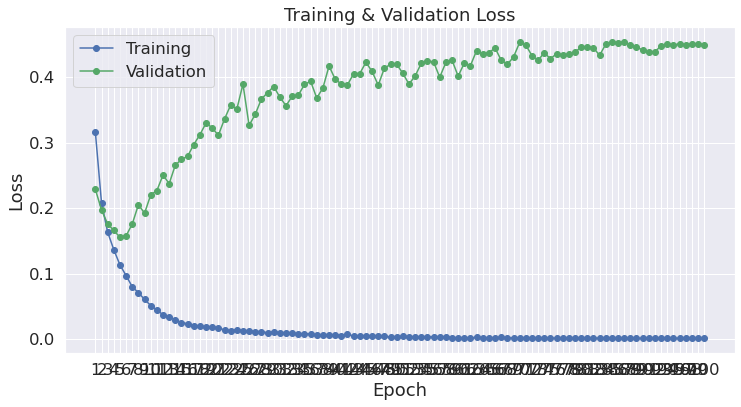

In [ ]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training_Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid_Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
num_list = []
for i in range(100):
    num_list.append(i+1)
plt.xticks(num_list)

plt.show()

In [ ]:
# Hamming loss is the fraction of labels that are incorrectly predicted
from sklearn.metrics import hamming_loss

print(f"Hamming Loss: {hamming_loss(y_test, np.round(probs))}")

Hamming Loss: 0.059509918319719954


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
result = np.round(probs)
# Compute ROC curve and ROC area for each class
n_classes = len(df_sentiment.columns[4:])
print(n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], result[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], result[:, i])

df_sentiment.columns[5:]

8


Index(['Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault',
       'Accident', 'Non-Crime'],
      dtype='object')

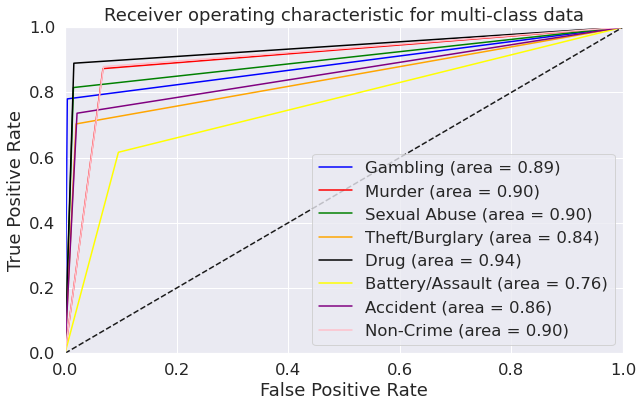

In [ ]:
from itertools import cycle
import matplotlib.pyplot as plt
news_label = ['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault', 'Accident', 'Non-Crime']
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'yellow', 'purple', 'pink', 'grey'])
plt.figure(figsize=(10,6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'{news_label[i]} (area = {roc_auc[i]:.2f})')
#     plt.plot(fpr[i], tpr[i], color=color, linewidth=1.5, label=f'ROC curve of class {news_label[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
Confusion_Matrix_Result = multilabel_confusion_matrix(y_test,result)
Labellist = ['Gambling', 'Murder', 'Sexual Abuse', 'Theft/Burglary', 'Drug', 'Battery/Assault', 'Accident', 'Non-Crime']

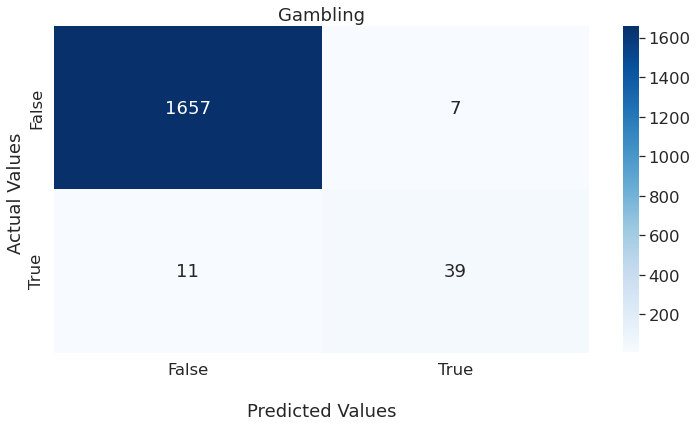

In [ ]:
import seaborn as sns

ax = sns.heatmap(Confusion_Matrix_Result[0], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[0]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

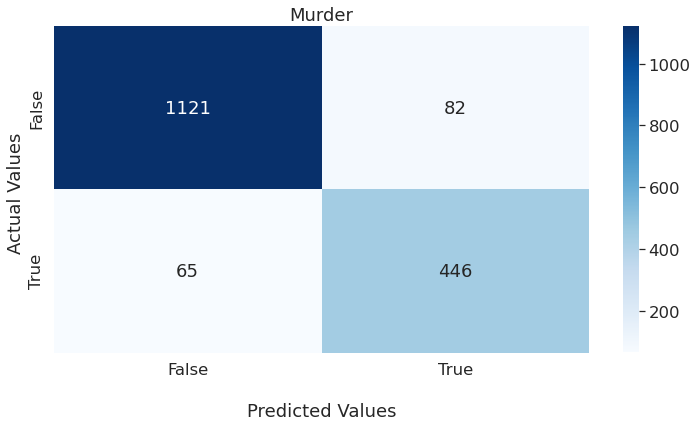

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[1], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[1]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

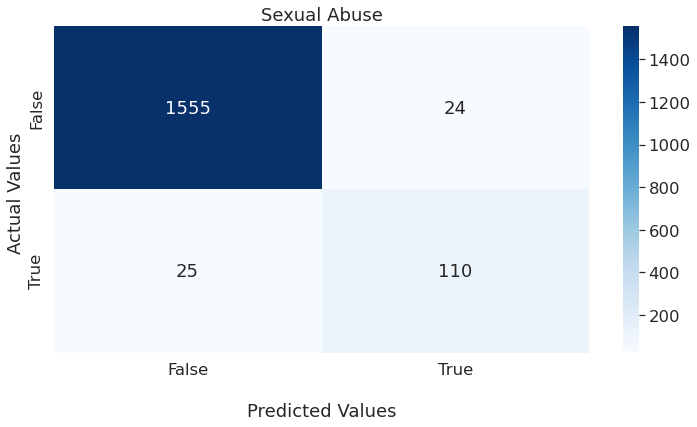

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[2], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[2]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

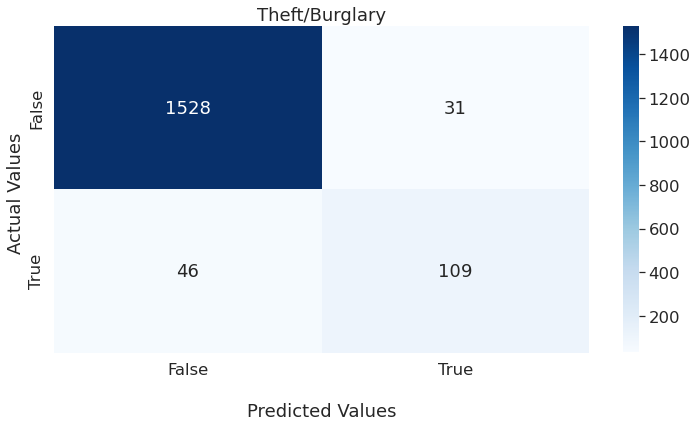

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[3], annot=True, cmap='Blues',fmt='g')

ax.set_title(news_label[3]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

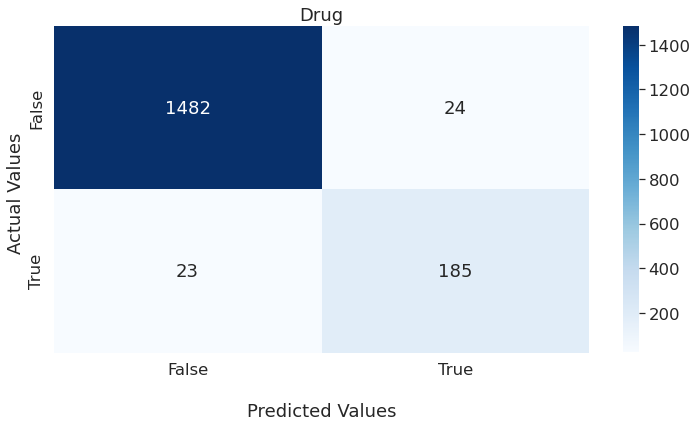

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[4], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[4]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

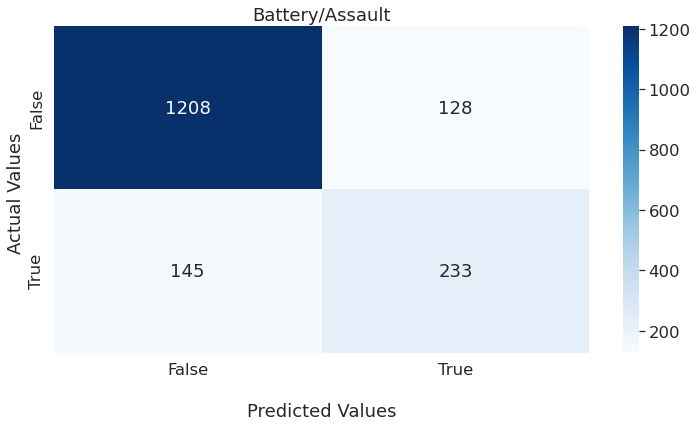

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[5], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[5]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

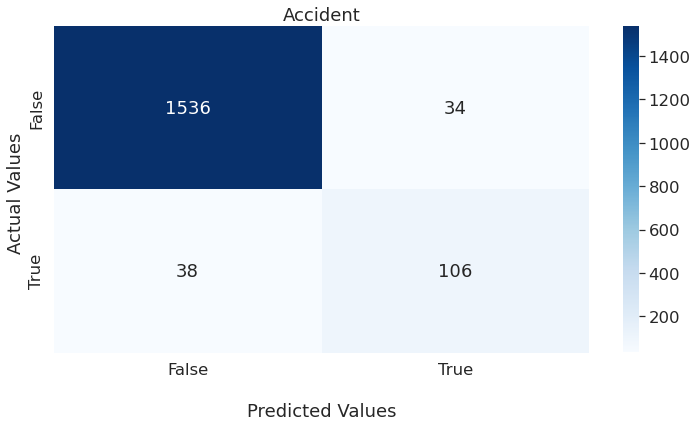

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[6], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[6]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

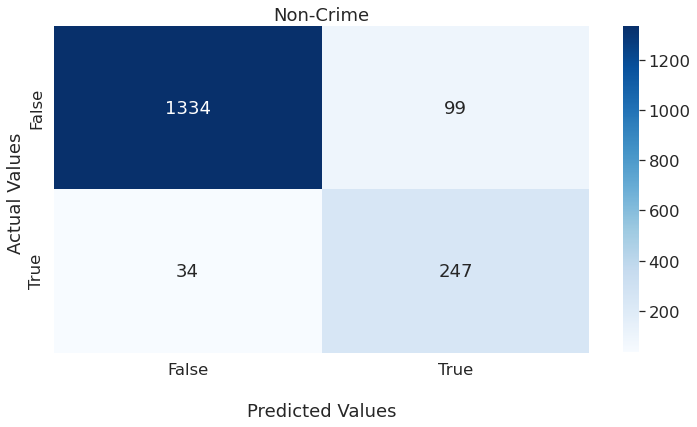

In [ ]:
ax = sns.heatmap(Confusion_Matrix_Result[7], annot=True, cmap='Blues',fmt='g')

ax.set_title(Labellist[7]);
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()